# 1️⃣ Setup + load data

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    r2_score
)

from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR

import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "../../data/processed/institute_level_most_recent_processed.csv"

df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())



Data shape: (5650, 33)
Columns: ['UNITID', 'INSTNM', 'CITY', 'STABBR', 'LATITUDE', 'LONGITUDE', 'PCIP14', 'PCIP15', 'ENG_TOTAL', 'ENG_RATIO', 'PCIP11', 'STEM_TOTAL', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'COSTT4_A', 'TUITION_GAP', 'AFFORDABILITY_INDEX', 'MD_EARN_WNE_P10', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'QUALITY_SCORE', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT']


# 2️⃣ Define a non-trivial “value” label

Here I’ll define a VALUE_LABEL:

1 = high quality AND affordable

0 = otherwise

…and I purposely do NOT use COSTT4_A or QUALITY_SCORE as features, to avoid the trivial 1.0 metrics you saw before.

In [2]:
df = df.copy()

# Basic checks
for col in ["COSTT4_A", "QUALITY_SCORE"]:
    if col not in df.columns:
        raise ValueError(f"Column {col} is missing. Check your preprocessing.")

# Build a value label:
cost_med = df["COSTT4_A"].median()
quality_med = df["QUALITY_SCORE"].median()

df["VALUE_LABEL"] = (
    (df["COSTT4_A"] <= cost_med) &
    (df["QUALITY_SCORE"] >= quality_med)
).astype(int)

print("VALUE_LABEL distribution:")
print(df["VALUE_LABEL"].value_counts(dropna=False))


VALUE_LABEL distribution:
VALUE_LABEL
0    3902
1    1748
Name: count, dtype: int64


# Choose feature columns (no direct label leakage)

We’ll exclude: COSTT4_A, QUALITY_SCORE, AFFORDABILITY_INDEX from X.

In [3]:
feature_cols = [
    "ENG_RATIO", "STEM_RATIO",
    "ENG_HEAVY", "STEM_HEAVY",
    "UGDS", "UGDS_MEN", "UGDS_WOMEN",
    "DIVERSITY_SCORE",
    "TUITIONFEE_IN", "TUITIONFEE_OUT", "TUITION_GAP",
    "RET_FT4", "GRAD_RATE", "ADM_RATE",
    "MD_EARN_WNE_P10",
    "CONTROL", "IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"
]

# Keep only available columns
feature_cols = [c for c in feature_cols if c in df.columns]
print("Using features:", feature_cols)

# Drop rows missing target or all features
df_model = df.dropna(subset=["VALUE_LABEL"])
X = df_model[feature_cols]
y = df_model["VALUE_LABEL"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Using features: ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITION_GAP', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'MD_EARN_WNE_P10', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT']
Train size: 4520
Test size: 1130


# Mutual information (feature vs target)

Mutual information (high -> low):
MD_EARN_WNE_P10    0.279518
TUITIONFEE_IN      0.098207
TUITIONFEE_OUT     0.067045
RET_FT4            0.053607
UGDS               0.049083
TUITION_GAP        0.045786
UGDS_WOMEN         0.028844
CONTROL            0.028392
UGDS_MEN           0.023334
DIVERSITY_SCORE    0.020978
ADM_RATE           0.016777
STEM_RATIO         0.012402
IS_PUBLIC          0.011504
IS_PRIVATE         0.006182
ENG_RATIO          0.006102
ENG_HEAVY          0.000000
STEM_HEAVY         0.000000
GRAD_RATE          0.000000
IS_FORPROFIT       0.000000
dtype: float64


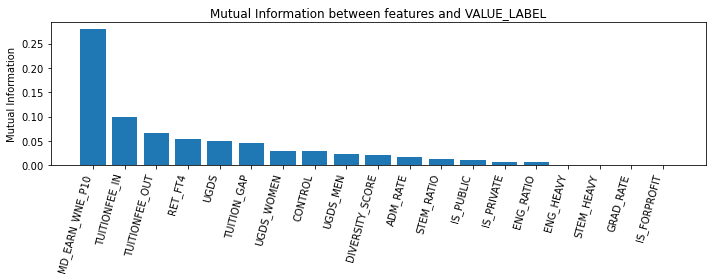

In [4]:

from sklearn.feature_selection import mutual_info_classif
import numpy as np
import matplotlib.pyplot as plt

# Ensure X_train, y_train exist
X_mi = X_train[feature_cols].copy()
y_mi = y_train.copy()

mi = mutual_info_classif(X_mi.fillna(0), y_mi, discrete_features='auto', random_state=42)
mi_series = (pd.Series(mi, index=feature_cols)
               .sort_values(ascending=False))

print("Mutual information (high -> low):")
print(mi_series)

# Plot
plt.figure(figsize=(10,4))
plt.bar(mi_series.index, mi_series.values)
plt.xticks(rotation=75, ha='right')
plt.ylabel('Mutual Information')
plt.title('Mutual Information between features and VALUE_LABEL')
plt.tight_layout()
plt.show()


# UMAP visualization

/home/antaradas/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/apps/python/3.10/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


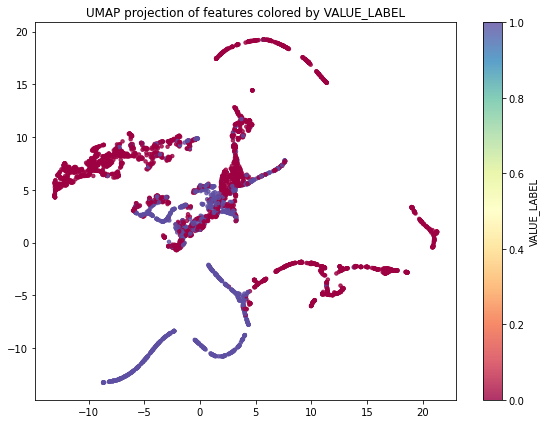

In [5]:

try:
    import umap
except Exception as e:
    print("umap not installed. Install with: pip install umap-learn")
    raise

import matplotlib.pyplot as plt

X_vis = X_train[feature_cols].fillna(0).values
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X_vis)

plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], c=y_train.map({0:0,1:1}), cmap='Spectral', s=12, alpha=0.8)
plt.colorbar(label='VALUE_LABEL')
plt.title('UMAP projection of features colored by VALUE_LABEL')
plt.tight_layout()
plt.show()


#  PCA analysis for the features used in value model applying standard scaler as the columns are not related and have widely different data values



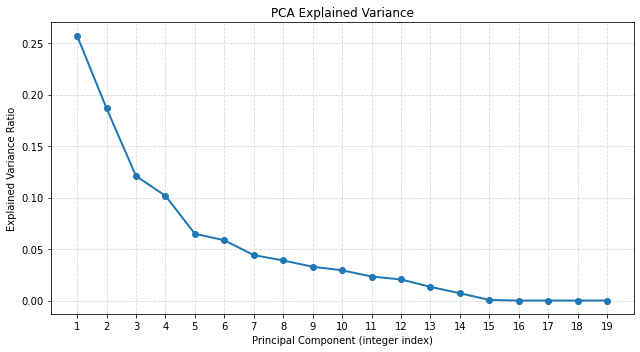

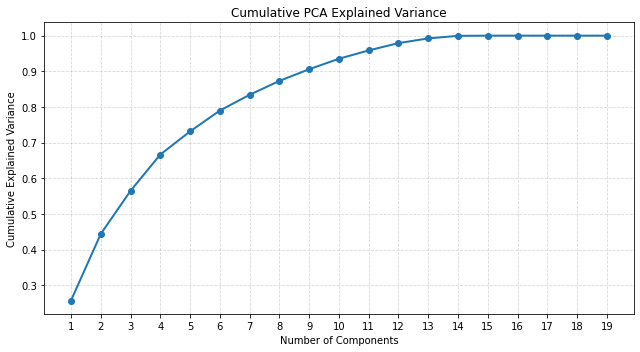

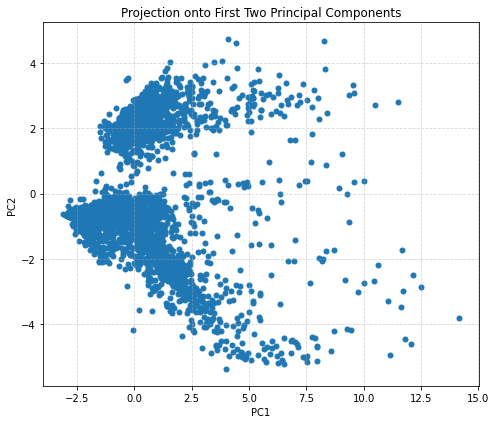


=== PCA Feature Rankings (Most → Least Important) ===
1. IS_PRIVATE: 0.0556
2. UGDS_MEN: 0.0556
3. TUITIONFEE_IN: 0.0556
4. ENG_RATIO: 0.0556
5. IS_FORPROFIT: 0.0556
6. TUITIONFEE_OUT: 0.0556
7. IS_PUBLIC: 0.0556
8. MD_EARN_WNE_P10: 0.0556
9. DIVERSITY_SCORE: 0.0556
10. CONTROL: 0.0556
11. UGDS_WOMEN: 0.0556
12. UGDS: 0.0556
13. RET_FT4: 0.0556
14. ADM_RATE: 0.0556
15. STEM_RATIO: 0.0556
16. TUITION_GAP: 0.0556
17. STEM_HEAVY: 0.0556
18. ENG_HEAVY: 0.0556
19. GRAD_RATE: 0.0000


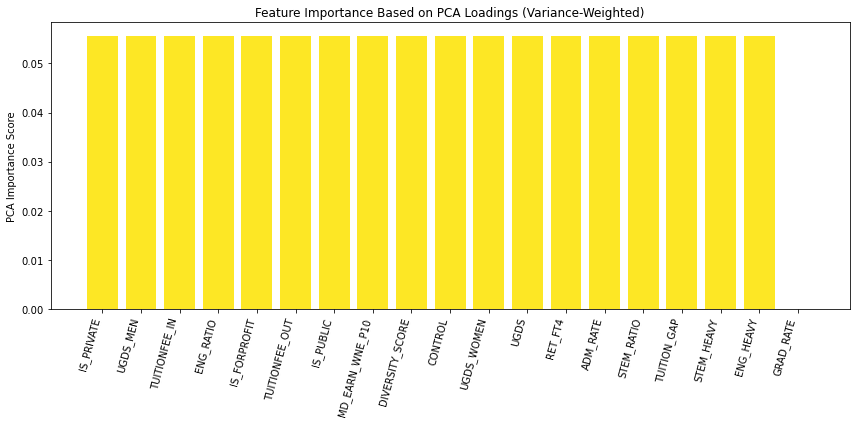

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --------------------
# PREPARE FEATURES
# --------------------
X_raw = X_train[feature_cols].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# --------------------
# RUN PCA
# --------------------
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

expl_var = pca.explained_variance_ratio_
cumvar = expl_var.cumsum()
components = np.arange(1, len(expl_var) + 1)

# --------------------
# PLOT 1 — Explained Variance
# --------------------
plt.figure(figsize=(9, 5))
plt.plot(components, expl_var, marker="o", linewidth=2)
plt.xticks(components)
plt.xlabel("Principal Component (integer index)")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --------------------
# PLOT 2 — Cumulative Explained Variance
# --------------------
plt.figure(figsize=(9, 5))
plt.plot(components, cumvar, marker="o", linewidth=2)
plt.xticks(components)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative PCA Explained Variance")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --------------------
# PLOT 3 — PC1 vs PC2 Scatter
# --------------------
plt.figure(figsize=(7, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=25)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Projection onto First Two Principal Components")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --------------------
# FEATURE IMPORTANCE FROM PCA
# --------------------
loadings = pca.components_        # components x features
importance = (expl_var @ (loadings**2))   # variance-weighted contribution

sorted_idx = np.argsort(importance)[::-1]
sorted_features = np.array(feature_cols)[sorted_idx]
sorted_scores = importance[sorted_idx]

print("\n=== PCA Feature Rankings (Most → Least Important) ===")
for i, (f, s) in enumerate(zip(sorted_features, sorted_scores), 1):
    print(f"{i}. {f}: {s:.4f}")

# --------------------
# PLOT 4 — Heat-Coded Bar Chart of Feature Contributions
# --------------------
plt.figure(figsize=(12, 6))

# Normalize scores for colormap use
norm_scores = (sorted_scores - sorted_scores.min()) / (sorted_scores.max() - sorted_scores.min())
colors = plt.cm.viridis(norm_scores)

plt.bar(range(len(sorted_scores)), sorted_scores, color=colors)
plt.xticks(range(len(sorted_scores)), sorted_features, rotation=75, ha='right')
plt.ylabel("PCA Importance Score")
plt.title("Feature Importance Based on PCA Loadings (Variance-Weighted)")
plt.tight_layout()
plt.show()


## After removing standard scaler

Since all the features show equal weight

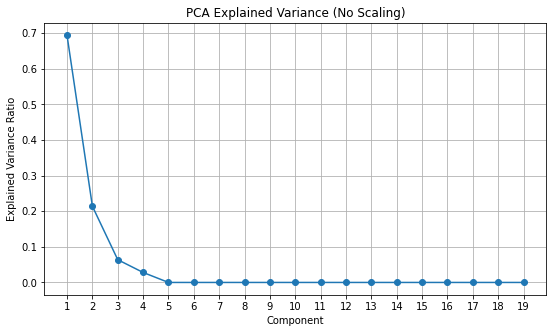


Feature importance without scaling:
1. MD_EARN_WNE_P10: 0.4122
2. TUITIONFEE_IN: 0.2691
3. TUITIONFEE_OUT: 0.2303
4. UGDS: 0.0568
5. TUITION_GAP: 0.0316
6. CONTROL: 0.0000
7. IS_FORPROFIT: 0.0000
8. IS_PUBLIC: 0.0000
9. IS_PRIVATE: 0.0000
10. DIVERSITY_SCORE: 0.0000
11. UGDS_WOMEN: 0.0000
12. UGDS_MEN: 0.0000
13. STEM_HEAVY: 0.0000
14. ENG_HEAVY: 0.0000
15. STEM_RATIO: 0.0000
16. ADM_RATE: 0.0000
17. RET_FT4: 0.0000
18. ENG_RATIO: 0.0000
19. GRAD_RATE: 0.0000


In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# ----- NO SCALING -----
X_raw = X_train[feature_cols].dropna()

pca_raw = PCA()
X_pca_raw = pca_raw.fit_transform(X_raw)

expl_var = pca_raw.explained_variance_ratio_
cumvar = expl_var.cumsum()
components = np.arange(1, len(expl_var) + 1)

plt.figure(figsize=(9,5))
plt.plot(components, expl_var, marker='o')
plt.xticks(components)
plt.title("PCA Explained Variance (No Scaling)")
plt.xlabel("Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

# Compute importance using unscaled PCA
loadings = pca_raw.components_
importance = (expl_var @ (loadings**2))

sorted_idx = np.argsort(importance)[::-1]
sorted_features = np.array(feature_cols)[sorted_idx]
sorted_scores = importance[sorted_idx]

print("\nFeature importance without scaling:")
for i, (f, s) in enumerate(zip(sorted_features, sorted_scores), 1):
    print(f"{i}. {f}: {s:.4f}")


#  PCA analysis for the features used in median earning applying standard scaler as the columns are not related and have widely different data values (pre‑model diagnostic)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from IPython.display import display

# ------------------------------------------------------------
# Paths (adjust if needed)
# ------------------------------------------------------------
CANDIDATE_INSTITUTION = [
    "../../data/processed/institute_level_most_recent_processed.csv"
]

def pick_path(candidates):
    for p in candidates:
        if Path(p).exists():
            return p
    raise FileNotFoundError(f"None of these paths exist: {candidates}")

DATA_PATH = pick_path(CANDIDATE_INSTITUTION)
print("Using DATA_PATH:", DATA_PATH)

# ------------------------------------------------------------
# Load data (institution-level only)
# ------------------------------------------------------------
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

TARGET = "MD_EARN_WNE_P10"
if TARGET not in df.columns:
    raise ValueError(f"Target {TARGET} not found in data")

# ------------------------------------------------------------
# VALUE_LABEL for classification (same definition as before)
# ------------------------------------------------------------
cost_med = df["COSTT4_A"].median()
quality_med = df["QUALITY_SCORE"].median()
df["VALUE_LABEL"] = ((df["COSTT4_A"] <= cost_med) & (df["QUALITY_SCORE"] >= quality_med)).astype(int)

print("VALUE_LABEL distribution:")
print(df["VALUE_LABEL"].value_counts(dropna=False))

# ------------------------------------------------------------
# Features (institution-level only)
# ------------------------------------------------------------
base_features_reg = [
    "ENG_RATIO", "STEM_RATIO",
    "ENG_HEAVY", "STEM_HEAVY",
    "UGDS", "UGDS_MEN", "UGDS_WOMEN",
    "DIVERSITY_SCORE",
    "TUITIONFEE_IN", "TUITIONFEE_OUT", "TUITION_GAP",
    "COSTT4_A", "RET_FT4", "GRAD_RATE", "ADM_RATE",
    "QUALITY_SCORE",
    "CONTROL", "IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT",
]
# For classification, drop the label-defining fields to avoid leakage
base_features_cls = [
    "ENG_RATIO", "STEM_RATIO",
    "ENG_HEAVY", "STEM_HEAVY",
    "UGDS", "UGDS_MEN", "UGDS_WOMEN",
    "DIVERSITY_SCORE",
    "TUITIONFEE_IN", "TUITIONFEE_OUT", "TUITION_GAP",
    "RET_FT4", "GRAD_RATE", "ADM_RATE",
    "CONTROL", "IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT",
]

feature_cols_reg = [c for c in base_features_reg if c in df.columns]
feature_cols_cls = [c for c in base_features_cls if c in df.columns]
print("Regression features:", feature_cols_reg)
print("Classification features (no leakage):", feature_cols_cls)

# Classification data
cls_df = df.dropna(subset=["VALUE_LABEL"])
X_cls = cls_df[feature_cols_cls]
y_cls = cls_df["VALUE_LABEL"]
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)
print("Classification train size:", Xc_train.shape[0])
print("Classification test size:", Xc_test.shape[0])

# Regression data (earnings target)
reg_df = df.dropna(subset=[TARGET])
X_reg = reg_df[feature_cols_reg]
y_reg = reg_df[TARGET]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
print("Regression train size:", Xr_train.shape[0])
print("Regression test size:", Xr_test.shape[0])

Using DATA_PATH: institute_most_recent_processed.csv
Data shape: (5650, 33)
Columns: ['UNITID', 'INSTNM', 'CITY', 'STABBR', 'LATITUDE', 'LONGITUDE', 'PCIP14', 'PCIP15', 'ENG_TOTAL', 'ENG_RATIO', 'PCIP11', 'STEM_TOTAL', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'COSTT4_A', 'TUITION_GAP', 'AFFORDABILITY_INDEX', 'MD_EARN_WNE_P10', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'QUALITY_SCORE', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT']
VALUE_LABEL distribution:
VALUE_LABEL
0    3902
1    1748
Name: count, dtype: int64
Regression features: ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITION_GAP', 'COSTT4_A', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'QUALITY_SCORE', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT']
Classification features (no leakage): ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', '

Number of features: 20
Explained variance ratio (first 10 PCs):
[0.25789121 0.20185373 0.11428211 0.1040443  0.07081431 0.05784492
 0.04215122 0.04005897 0.03253016 0.02729784]
Cumulative variance (first 10 PCs):
[0.25789121 0.45974494 0.57402706 0.67807136 0.74888567 0.80673059
 0.84888181 0.88894078 0.92147094 0.94876878]


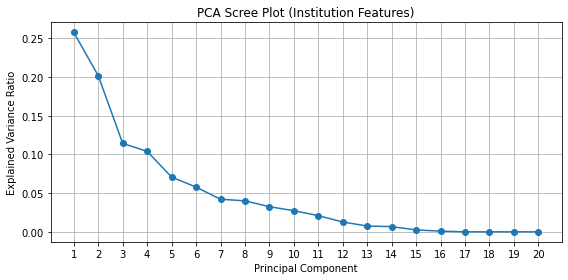

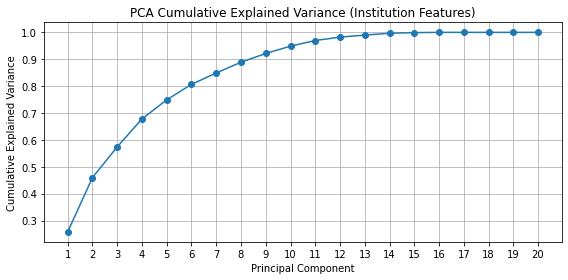


Top loadings on PC1:
TUITIONFEE_OUT    0.348939
TUITIONFEE_IN     0.334465
COSTT4_A          0.329560
STEM_RATIO        0.323121
QUALITY_SCORE     0.311680
STEM_HEAVY        0.267284
IS_PRIVATE        0.252659
ENG_RATIO         0.227592
UGDS_MEN          0.197369
ENG_HEAVY         0.191782
Name: PC1, dtype: float64

Most negative on PC1:
IS_FORPROFIT      -2.166387e-01
ADM_RATE          -2.064255e-01
UGDS_WOMEN        -1.958281e-01
CONTROL           -1.151738e-01
TUITION_GAP       -3.256639e-02
IS_PUBLIC         -1.632741e-02
GRAD_RATE         -1.615587e-27
UGDS               1.053463e-01
DIVERSITY_SCORE    1.098674e-01
RET_FT4            1.665841e-01
Name: PC1, dtype: float64

Using first 11 PCs (cumulative variance = 0.970)

=== PCA Feature Rankings (Most → Least Important) using first 11 PCs ===
1. IS_FORPROFIT: 0.0526
2. ADM_RATE: 0.0526
3. DIVERSITY_SCORE: 0.0526
4. CONTROL: 0.0525
5. UGDS: 0.0525
6. TUITION_GAP: 0.0524
7. IS_PRIVATE: 0.0524
8. IS_PUBLIC: 0.0524
9. UGDS_WOMEN: 0.

,rank,feature,score
0,1,IS_FORPROFIT,0.0526
1,2,ADM_RATE,0.0526
2,3,DIVERSITY_SCORE,0.0526
3,4,CONTROL,0.0525
4,5,UGDS,0.0525
5,6,TUITION_GAP,0.0524
6,7,IS_PRIVATE,0.0524
7,8,IS_PUBLIC,0.0524
8,9,UGDS_WOMEN,0.0522
9,10,UGDS_MEN,0.0522


/scratch/local/20119656/ipykernel_3285540/242277151.py:134: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, pad=0.02)


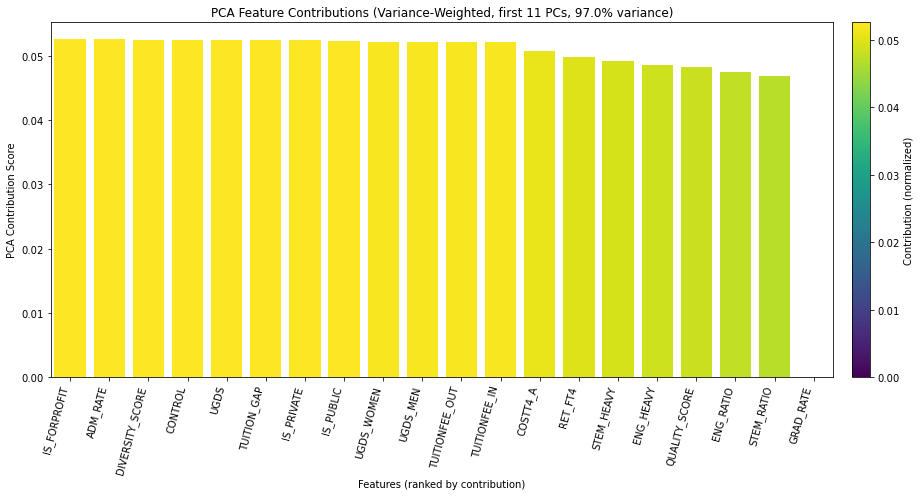

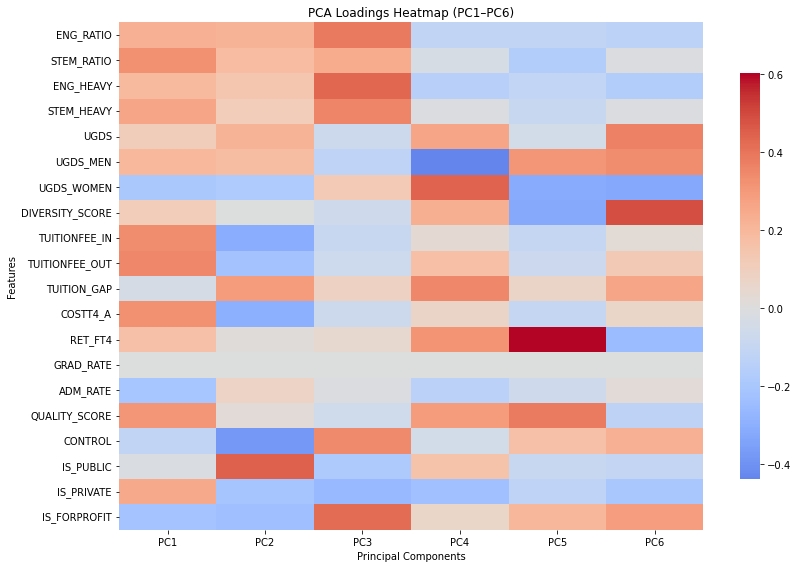

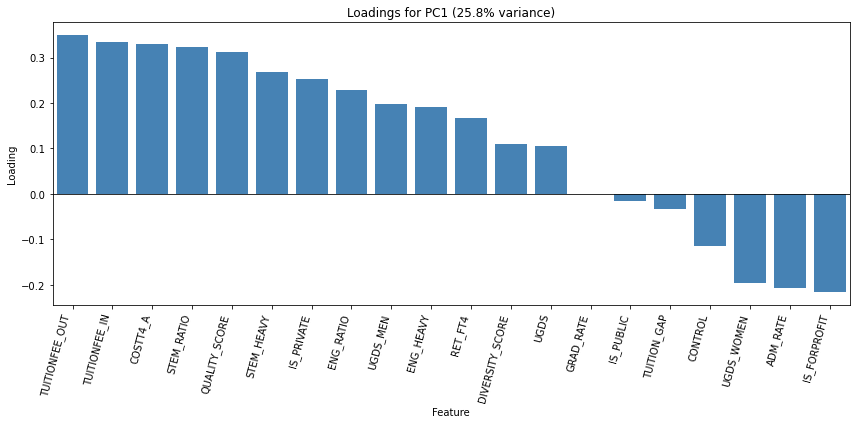

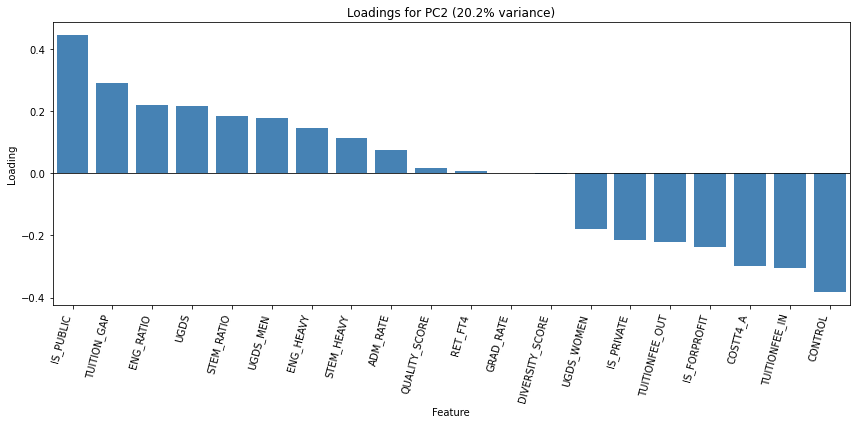

In [9]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------
# PCA ON REGRESSION FEATURES (pre‑model diagnostic)
# ------------------------------------------------------------

# 1. Prepare feature matrix
X_all = df[feature_cols_reg].copy()
X_all = X_all.dropna(how="all")

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X_all)
X_scaled = scaler.fit_transform(X_imputed)

# 2. Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

expl_var = pca.explained_variance_ratio_
feature_cols = feature_cols_reg

print("Number of features:", X_scaled.shape[1])
print("Explained variance ratio (first 10 PCs):")
print(expl_var[:10])
print("Cumulative variance (first 10 PCs):")
print(expl_var[:10].cumsum())

# 3. Scree plots WITH INTEGER X-AXIS
plt.figure(figsize=(8, 4))
pc_indices = np.arange(1, len(expl_var) + 1)
plt.plot(pc_indices, expl_var, marker="o")
plt.xticks(pc_indices.astype(int))  # Force integer ticks
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot (Institution Features)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(pc_indices, expl_var.cumsum(), marker="o")
plt.xticks(pc_indices.astype(int))  # Force integer ticks
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance (Institution Features)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Loadings matrix
loadings_df = pd.DataFrame(
    pca.components_.T,
    index=feature_cols,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print("\nTop loadings on PC1:")
print(loadings_df["PC1"].sort_values(ascending=False).head(10))
print("\nMost negative on PC1:")
print(loadings_df["PC1"].sort_values().head(10))

# ------------------------------------------------------------
# 5. Automatic m selection (95% cumulative variance)
# ------------------------------------------------------------
target_cum_var = 0.95
cum_var = expl_var.cumsum()
m = np.argmax(cum_var >= target_cum_var) + 1  # first PC where cum_var >= 0.95
m = min(m, len(expl_var))  # safety

print(f"\nUsing first {m} PCs (cumulative variance = {cum_var[m-1]:.3f})")

# 6. PCA feature importance (variance‑weighted)
loadings = pca.components_[:m, :]          # shape: (m, n_features)
expl_var_m = expl_var[:m]                  # shape: (m,)

importance = expl_var_m @ (loadings ** 2)  # shape: (n_features,)

sorted_idx = np.argsort(importance)[::-1]
sorted_features = np.array(feature_cols)[sorted_idx]
sorted_scores = importance[sorted_idx]

print(f"\n=== PCA Feature Rankings (Most → Least Important) using first {m} PCs ===")
for i, (f, s) in enumerate(zip(sorted_features, sorted_scores), 1):
    print(f"{i}. {f}: {s:.4f}")

# ------------------------------------------------------------
# 7. Contribution "heat‑map bargraph" WITH INTEGER X-POSITIONS
# ------------------------------------------------------------

plt.figure(figsize=(14, 7))

score_min, score_max = sorted_scores.min(), sorted_scores.max()
norm_scores = (sorted_scores - score_min) / (score_max - score_min + 1e-12)

cmap = plt.cm.viridis
colors = cmap(norm_scores)

n_feats = len(sorted_scores)
x_pos = np.arange(n_feats)  # 0, 1, 2, ..., n_feats-1

plt.bar(x_pos, sorted_scores, color=colors, align="center")

# FEATURE NAMES with explicit integer positions
plt.xticks(x_pos, sorted_features, rotation=75, ha="right")
plt.xlim(-0.5, n_feats - 0.5)

plt.xlabel("Features (ranked by contribution)")
plt.ylabel("PCA Contribution Score")
plt.title(f"PCA Feature Contributions (Variance‑Weighted, first {m} PCs, {cum_var[m-1]:.1%} variance)")

# Reference table
pca_rank_df = pd.DataFrame({
    "rank": np.arange(1, n_feats + 1),
    "feature": sorted_features,
    "score": sorted_scores.round(4)
})
print("\nFeature ranking table:")
display(pca_rank_df.head(10))

sm = mpl.cm.ScalarMappable(
    cmap=cmap,
    norm=mpl.colors.Normalize(vmin=score_min, vmax=score_max)
)
sm.set_array([])
cbar = plt.colorbar(sm, pad=0.02)
cbar.set_label("Contribution (normalized)")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 8. LOADINGS PLOTS WITH INTEGER POSITIONING
# ------------------------------------------------------------

# 8a. Heatmap of loadings for first k PCs
k = min(6, pca.n_components_)
plt.figure(figsize=(12, 8))
sns.heatmap(
    loadings_df.iloc[:, :k],
    annot=False,
    cmap="coolwarm",
    center=0,
    cbar_kws={"shrink": 0.8}
)
plt.title(f"PCA Loadings Heatmap (PC1–PC{k})")
plt.ylabel("Features")
plt.xlabel("Principal Components")
plt.tight_layout()
plt.show()

# 8b. Bar plots of loadings for PC1 and PC2 WITH INTEGER X-AXIS
for pc_idx in [0, 1]:
    if pc_idx >= pca.n_components_:
        break
    pc_name = f"PC{pc_idx+1}"
    loadings_pc = loadings_df[pc_name].sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    x_pos_pc = np.arange(len(loadings_pc))  # integer positions
    plt.bar(x_pos_pc, loadings_pc.values, color="steelblue")
    plt.xticks(x_pos_pc, loadings_pc.index, rotation=75, ha="right")
    plt.axhline(0, color="black", linewidth=0.8)
    plt.ylabel("Loading")
    plt.xlabel("Feature")
    plt.title(f"Loadings for {pc_name} ({expl_var[pc_idx]:.1%} variance)")
    plt.xlim(-0.5, len(loadings_pc) - 0.5)
    plt.tight_layout()
    plt.show()


The equal contributions come from how the importance is being aggregated, not from the loadings themselves. With your formula

importance
j
=
∑
k
expl_var
k
⋅
loading
k
,
j
2
importance 
j
 = 
k
∑
 expl_var 
k
 ⋅loading 
k,j
2
 
each feature’s squared loadings across all components are weighted by explained variance, but:

The total of 
loading
k
,
j
2
loading 
k,j
2
  over features is 1 for each component 
k
k (orthonormal eigenvectors).​

If your data are well‑scaled and many features contribute similarly to the main PCs, the variance‑weighted sum can easily be very close for many features, especially when you keep all components.

So you’re seeing nearly equal importance values because PCA, by construction, redistributes variance across orthogonal directions, and the specific loading pattern you have happens to give similar variance‑weighted sums across features. For stronger separation, you can:​

Restrict to first 
m
m PCs (e.g., where cumulative variance ≤ 90%).

Or use 
∣
loading
1
,
j
∣
∣loading 
1,j
 ∣ or 
∣
loading
k
,
j
∣
∣loading 
k,j
 ∣ on a few top PCs instead of aggregating across all.